<h1>How to get corner plots of the posterior with sbi</h1>
<div class="text">
    In this tutorial, I will show how to use the functions I created for the training of the NDE, in particular the Mixture Density Network (MDN), which a probability distribution given by the is the sum of gaussians. We can also choose the number of gaussians.
</div>

In [10]:
import sys
import os
import numpy as np
import torch

sys.path.insert(1, os.path.abspath('../')) # Note that this line is useless with a regular pip installation of PyWST.
import pietrosbi as psbi

<h2>Importing the data of the statistics PS, S1, S2, PS3d</h2>

In [2]:
# Import the data as shown in tutorial 3

# Path to the folder with all the .npy files
path_to_folder = '/travail/pguidi/correct_data/'

# Loading the 'observation' and the true paramaters
data_obs_S1 = np.load(path_to_folder + 'data_obs_S1_1000.npy')
print('Obs. S1 has been loaded', type(data_obs_S1), data_obs_S1.shape)
data_obs_PS = np.load(path_to_folder + 'data_obs_PS_1000.npy')
print('Obs. PS has been loaded', type(data_obs_PS), data_obs_PS.shape)
data_obs_PS3d = np.load(path_to_folder + 'data_obs_PS3d_1000.npy')
print('Obs. PS3d has been loaded', type(data_obs_PS3d), data_obs_PS3d.shape)
data_obs_S2 = np.load(path_to_folder + 'data_obs_S2_1000.npy')
print('Obs. S2 has been loaded', type(data_obs_S2), data_obs_S2.shape)
param_true = np.load(path_to_folder + 'param_true_1000.npy')[:2]
print('Obs. param. has been loaded', type(param_true), param_true.shape)

# Loading the simulated S1, PS, S2, PS3d and the list of parameters used in these simulations
data_S1 = psbi.import_data_test(path_to_folder + 'data_summary_S1_1000_[0-9].npy')
print('Simulated S1 have been loaded', type(data_S1), data_S1.shape)
data_PS = psbi.import_data_test(path_to_folder + 'data_summary_PS_1000_[0-9].npy')
print('Simulated PS have been loaded', type(data_PS), data_PS.shape)
data_PS3d = psbi.import_data_test(path_to_folder + 'data_summary_PS3d_1000_[0-9].npy')
print('Simulated PS3d have been loaded', type(data_PS3d), data_PS3d.shape)
data_S2 = psbi.import_data_test(path_to_folder + 'data_summary_S2_1000_[0-9].npy')
print('Simulated S2 have been loaded', type(data_S2), data_S2.shape)
param_list = psbi.import_data_test(path_to_folder + 'param_list_1000_[0-9].npy')[:,:2]
print('Simulated params have been loaded', type(param_list), param_list.shape)

Obs. S1 has been loaded <class 'numpy.ndarray'> (32, 6)
Obs. PS has been loaded <class 'numpy.ndarray'> (32, 6)
Obs. PS3d has been loaded <class 'numpy.ndarray'> (6,)
Obs. S2 has been loaded <class 'numpy.ndarray'> (32, 6, 6)
Obs. param. has been loaded <class 'numpy.ndarray'> (2,)
Simulated S1 have been loaded <class 'numpy.ndarray'> (1000, 32, 6)
Simulated PS have been loaded <class 'numpy.ndarray'> (1000, 32, 6)
Simulated PS3d have been loaded <class 'numpy.ndarray'> (1000, 6)
Simulated S2 have been loaded <class 'numpy.ndarray'> (1000, 32, 6, 6)
Simulated params have been loaded <class 'numpy.ndarray'> (1000, 2)


In [3]:
# Some of the paramters used for the simulation

# Number of pixels and dimension in Mpc
n_pixels = 32
dim = 300

# Number of bins for the statistics
bins = 6

# These three parameters are ignored since it doesn't calculate the ell summaries
l1 = True
l2 = True
wavelet_type = 'morl'


In [4]:
# This function calculates the l1 and l2 summaries for the simulated PS, S1 and S2.
# It also modifies the array from np.arrays with float64 values to torch.tensors with float32 values
# Float32 is needed for torch.tensor
l1l2_summary_PS, l1l2_summary_S1, l1l2_summary_S2, data_PS3d, param_list = psbi.l1l2_and_torchify_data(data_PS, 
                                                                                                       data_S1, 
                                                                                                       data_S2, 
                                                                                                       data_PS3d, 
                                                                                                       param_list,
                                                                                                       n_pixels, 
                                                                                                       wavelet_type,
                                                                                                       l1,
                                                                                                       l2
                                                                                                      )


# This function will give a runtime warning due to a division by 0.
# This happens during the normalization of S1 and S2 for the slices whose brightness temperature is 0 everywhere,
# so PS, S1 and S2 will be 0 and when I divide S1/PS I will basicallly have 0/0 = nan.
# Inside that function I substitute all the nan values with 0.

/mesopsl3/home/pguidi/files_github/pietrosbi/import_data_S1_S2_PS_PS3d.py:190: RuntimeWarning: invalid value encountered in divide
  data_S1_new = data_S1 / np.sqrt(data_PS)


In [5]:
# This function calculates the l1 and l2 summaries for the 'observed' PS, S1 and S2.
# It also modifies the array from np.arrays with float64 values to torch.tensors with float32 values
# Float32 is needed for torch.tensor
l1l2_summary_obs_PS, l1l2_summary_obs_S1, l1l2_summary_obs_S2, data_obs_PS3d, param_true = psbi.l1l2_and_torchify_obs_data(data_obs_PS, 
                                                                                                                           data_obs_S1, 
                                                                                                                           data_obs_S2, 
                                                                                                                           data_obs_PS3d, 
                                                                                                                           param_true,
                                                                                                                           n_pixels,
                                                                                                                           wavelet_type,
                                                                                                                           l1, 
                                                                                                                           l2                                                                                                                          
                                                                                                                          )

# This function will sometimes give a runtime warning due to a division by 0.
# This happens during the normalization of slices where the brightness temperature is 0 everywhere,
# so PS, S1 and S2 will be 0 and when I divide S1/PS I will basicallly have 0/0 = nan.
# Inside that function I assign the value 0 to all the nan.

In [6]:
#####################
# FOR THE POSTERIOR #
#####################

# For the posteriors: create a class which has all the function for the selection of the data, 
# concatenation of the data, training and creation of the posterior.
# This class should also have a function for loading the l1l2 summaries, PS3d and parameters.
# After that you can call the function posterior_corner() to plot the posterior


# Create an initialization of the class My_posterior()
# Afterwards you can call the functions to train the SBI and plot the posteriors
My_P = psbi.My_Posterior(data_l1l2_PS = l1l2_summary_PS, 
                         data_l1l2_S1 = l1l2_summary_S1,
                         data_l1l2_S2 = l1l2_summary_S2,
                         data_PS3d = data_PS3d,
                         param_list = param_list,
                         data_obs_l1l2_PS = l1l2_summary_obs_PS,
                         data_obs_l1l2_S1 = l1l2_summary_obs_S1,
                         data_obs_l1l2_S2 = l1l2_summary_obs_S2,
                         data_obs_PS3d = data_obs_PS3d,
                         param_true = param_true,
                        )


torch.Size([1000, 6]) torch.Size([6])
Density estimator was trained for 626 epochs


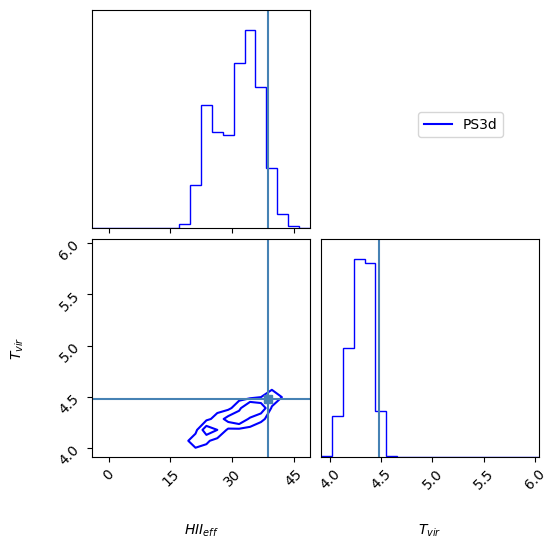

In [7]:
# Now you can call the function to plot the posterior.
# This function will call the training function and then it will plot the posterior
# In this example, it uses data_PS3d to train the NDE and output the posterior
# built_NDE = True means that it will use my training function
# built_NDE = False means that it will use the deafult training function (look tutorial 4)
# You could concatenate more datasets: ['PS3d', 'S1']
My_P.posterior_corner(['PS3d'], built_NDE = True)

torch.Size([1000, 6]) torch.Size([6])
torch.Size([1000, 420]) torch.Size([420])
Density estimator was trained for 468 epochs
Density estimator was trained for 134 epochs


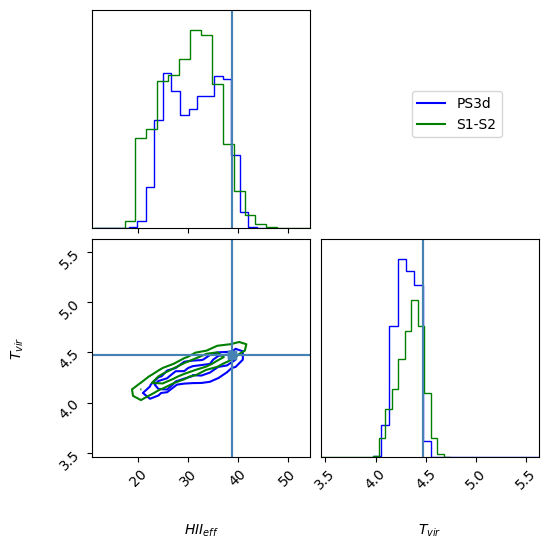

In [8]:
# This function will compare two data sets:
# One is PS3d and the other is the concatenation of S1 and S2
My_P.posterior_corner_pair(['PS3d'], ['S1','S2'], built_NDE = True)

<h2>Importing PS3d and the $\ell^1$ and $\ell^2$ summaries of PS, S1 and S2, </h2>

In [11]:
data_obs_S1 = psbi.import_obs_l1l2('/travail/pguidi/data_for_sbi_l1l2/data_obs_S1_l1l2_1000.npy')
print('Obs. S1 has been loaded', type(data_obs_S1), data_obs_S1.shape)
data_obs_PS = psbi.import_obs_l1l2('/travail/pguidi/data_for_sbi_l1l2/data_obs_PS_l1l2_1000.npy')
print('Obs. PS has been loaded', type(data_obs_PS), data_obs_PS.shape)
data_obs_PS3d = psbi.import_obs_l1l2('/travail/pguidi/data_for_sbi_l1l2/data_obs_PS3d_1000.npy')
print('Obs. PS3d has been loaded', type(data_obs_PS3d), data_obs_PS3d.shape)
data_obs_S2 = psbi.import_obs_l1l2('/travail/pguidi/data_for_sbi_l1l2/data_obs_S2_l1l2_1000.npy')
print('Obs. S2 has been loaded', type(data_obs_S2), data_obs_S2.shape)
param_true = np.load('/travail/pguidi/data_for_sbi_l1l2/param_true_1000.npy')[:2]
param_true = torch.from_numpy(np.float32(param_true))
print('Obs. param. has been loaded', type(param_true), param_true.shape)

data_S1 = psbi.import_data_l1l2('/travail/pguidi/data_for_sbi_l1l2/data_summary_S1_*.npy')
print('Simulated S1 have been loaded', type(data_S1), data_S1.shape)
data_PS = psbi.import_data_l1l2('/travail/pguidi/data_for_sbi_l1l2/data_summary_PS_*.npy')
print('Simulated PS have been loaded', type(data_PS), data_PS.shape)
data_PS3d = psbi.import_data_l1l2('/travail/pguidi/data_for_sbi_l1l2/data_summary_PS3d_*.npy')
print('Simulated PS3d have been loaded', type(data_PS3d), data_PS3d.shape)
data_S2 = psbi.import_data_l1l2('/travail/pguidi/data_for_sbi_l1l2/data_summary_S2_*.npy')
print('Simulated S2 have been loaded', type(data_S2), data_S2.shape)
param_list = psbi.import_data_l1l2('/travail/pguidi/data_for_sbi_l1l2/param_list_*.npy')
print('Simulated params have been loaded', type(param_list), param_list.shape)


Obs. S1 has been loaded <class 'torch.Tensor'> torch.Size([60])
Obs. PS has been loaded <class 'torch.Tensor'> torch.Size([60])
Obs. PS3d has been loaded <class 'torch.Tensor'> torch.Size([6])
Obs. S2 has been loaded <class 'torch.Tensor'> torch.Size([360])
Obs. param. has been loaded <class 'torch.Tensor'> torch.Size([2])
Simulated S1 have been loaded <class 'torch.Tensor'> torch.Size([1000, 60])
Simulated PS have been loaded <class 'torch.Tensor'> torch.Size([1000, 60])
Simulated PS3d have been loaded <class 'torch.Tensor'> torch.Size([1000, 6])
Simulated S2 have been loaded <class 'torch.Tensor'> torch.Size([1000, 360])
Simulated params have been loaded <class 'torch.Tensor'> torch.Size([1000, 2])


In [12]:
# Since we have imported the l1l2 summaries directly,
# we can immediately proceed to the initialization of the My_Posterior object
My_P = psbi.My_Posterior(data_l1l2_PS = data_PS, 
                         data_l1l2_S1 = data_S1,
                         data_l1l2_S2 = data_S2,
                         data_PS3d = data_PS3d,
                         param_list = param_list,
                         data_obs_l1l2_PS = data_obs_PS,
                         data_obs_l1l2_S1 = data_obs_S1,
                         data_obs_l1l2_S2 = data_obs_S2,
                         data_obs_PS3d = data_obs_PS3d,
                         param_true = param_true,
                        )


torch.Size([1000, 6]) torch.Size([6])
torch.Size([1000, 420]) torch.Size([420])
Density estimator was trained for 529 epochs
Density estimator was trained for 100 epochs


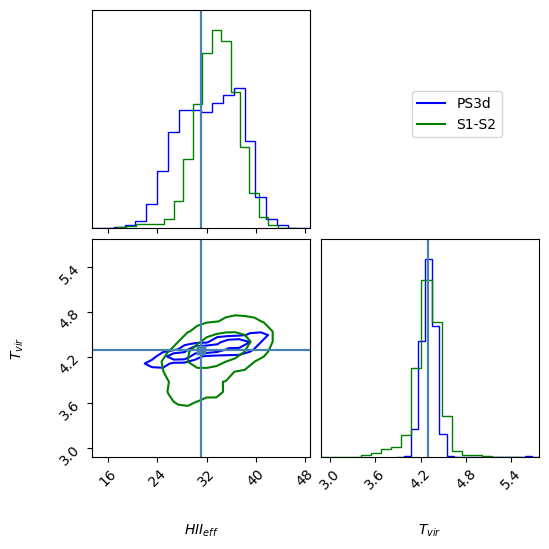

In [13]:
# This function will compare two data sets:
# One is PS3d and the other is the concatenation of S1 and S2
My_P.posterior_corner_pair(['PS3d'], ['S1','S2'], built_NDE = True)